In [1]:
import shapely as shapely
import pandas as pd
import geopandas as gpd

# Industry variety
data ref: Ravenna, June 2015  
data source: [Ravenna opendata](https://opendata.comune.ra.it/organization/comune-ravenna)  

**Indicator**: the aim of this indicator is to evaluate industry variety and distribution in each district.  
**Limitations**: companies' identifier codes are by physical office and VAT isn't provided in the open data, thus duplicates are removed by name to count the presence and types of economic activities; outdated data.

### Prepare data

                                            geometry    frazione
0  POLYGON ((284232.269 4930649.527, 284235.500 4...    DEL MARE
1  POLYGON ((275721.083 4917396.486, 275668.926 4...  RONCALCECI
2  POLYGON ((271213.347 4927446.004, 271222.387 4...  PIANGIPANE
epsg:32633


<AxesSubplot:>

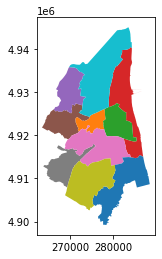

In [2]:
areas = gpd.read_file('aree.geojson')
areas = areas[["geometry", "NOME_AT"]] # epsg:3004
areas = areas.rename(columns = { "NOME_AT" : "frazione" })
areas = areas.set_crs("epsg:4326", allow_override=True)
areas = areas.to_crs(epsg = 32633) #utm
print(areas.head(3))
print(areas.crs)
areas.plot(column = "frazione")

In [3]:
ateco = pd.read_csv('ateco.csv', encoding='ISO-8859-1') # ateco classification of economic activities
print(ateco.head(3))

  ateco_cod                                         ateco_nome
0         U      Organizzazioni ed organismi extraterritoriali
1         T  Attività di famiglie e convivenze come datori ...
2         S                          Altre attività di servizi


In [4]:
imprese = gpd.read_file('imprese.geojson')
imprese = imprese[['DENOMINAZI', 'geometry', 'CODICE_ATT']]
imprese = imprese.to_crs(epsg = 32633) #utm
imprese = imprese.rename(columns = { 'DENOMINAZI' : 'nome', 'CODICE_ATT' : 'ateco' })
imprese = imprese.dropna( subset = ['ateco'] ) # delete unspecified companies
imprese['ateco'] = imprese['ateco'].str.replace('[A-Z]', '', regex=True) # the default value of regex will change from True to False in a future version
imprese['ateco'] = imprese['ateco'].str.replace(' ', '')
imprese_ateco = imprese['ateco'].str.split('/', expand = True)
imprese_ateco = imprese_ateco.add_prefix('ateco_')
imprese = imprese.drop(columns=['ateco'])
imprese = pd.concat([imprese, imprese_ateco], axis=1)
print('total number of companies:', imprese.shape[0])
print(imprese.head(3))

total number of companies: 16094
                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   
2  LEGATORIA TIMBRIFICIO UNIVERSO DI MARIO VERITA...   

                         geometry  ateco_0  ateco_1 ateco_2 ateco_3 ateco_4  \
0  POINT (272167.050 4922066.166)  45.20.2  45.20.1   77.11    None    None   
1  POINT (276997.507 4922289.211)     55.1     None    None    None    None   
2  POINT (278236.571 4925807.430)    18.14  32.99.9    None    None    None   

  ateco_5 ateco_6  
0    None    None  
1    None    None  
2    None    None  


check number of values by column

In [5]:
# occurrences_0 = imprese['ateco_0'].value_counts() # 897
# occurrences_1 = imprese['ateco_1'].value_counts() # 702
# occurrences_2 = imprese['ateco_2'].value_counts() # 501
# occurrences_3 = imprese['ateco_3'].value_counts() # 348
# occurrences_4 = imprese['ateco_4'].value_counts() # 249
# occurrences_5 = imprese['ateco_5'].value_counts() # 150
# occurrences_6 = imprese['ateco_6'].value_counts() # 13
# print(occurrences_0)

convert ateco codes to names

In [6]:
imprese = imprese[['nome', 'geometry', 'ateco_0']]
imprese = imprese.rename(columns = { 'ateco_0' : 'ateco_cod' })
ateco = ateco.drop_duplicates(subset=['ateco_cod']) # imprese rows increase if keys match more than one row in the other df
imprese = pd.merge(imprese, ateco, how='left', on='ateco_cod')
# error = imprese[imprese['ateco_nome'].isna()] # check if any code wasn't translated
print(imprese.head(3))

                                                nome  \
0        CASADIO & VANNINI DI GALLI ALBA E C. S.N.C.   
1  HOTEL BISANZIO-DI FABBRI DONATELLA & C.-SOCIET...   
2  LEGATORIA TIMBRIFICIO UNIVERSO DI MARIO VERITA...   

                         geometry ateco_cod  \
0  POINT (272167.050 4922066.166)   45.20.2   
1  POINT (276997.507 4922289.211)      55.1   
2  POINT (278236.571 4925807.430)     18.14   

                                  ateco_nome  
0  Riparazione di carrozzerie di autoveicoli  
1                Alberghi e strutture simili  
2               Legatoria e servizi connessi  


### Distribution

   frazione                                               nome ateco_cod  \
0  DEL MARE  FERRAMENTA ZANGAGLIA DI PAOLO E CLAUDIO ZANGAG...   47.19.9   
1  DEL MARE  ASSOCIAZIONE COOPERATIVA MURATORI & AFFINI RAV...      41.2   
2  DEL MARE                   BANCA POPOLARE DI RAVENNA S.P.A.   64.19.1   

                                          ateco_nome  \
0  Empori ed altri negozi non specializzati di va...   
1  Costruzione di edifici residenziali e non resi...   
2  Intermediazione monetaria di istituti monetari...   

                         geometry  
0  POINT (283771.377 4929581.233)  
1  POINT (284620.355 4924355.829)  
2  POINT (283506.762 4930217.509)  


<AxesSubplot:>

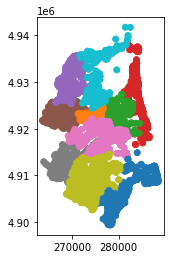

In [7]:
distribution = areas.overlay(imprese, how = "intersection", keep_geom_type=False)
distribution = distribution.drop_duplicates(subset = ['nome'], ignore_index=True)
print(distribution.head(3))
distribution.plot(column = "frazione")

                frazione  imprese_num
0            CASTIGLIONE          978
1          CENTRO URBANO         3885
2                DARSENA         1654
3               DEL MARE         1908
4                MEZZANO          629
5             PIANGIPANE          546
6            RAVENNA SUD         2997
7             RONCALCECI          445
8  SAN PIETRO IN VINCOLI          923
9           SANT'ALBERTO          498


<AxesSubplot:>

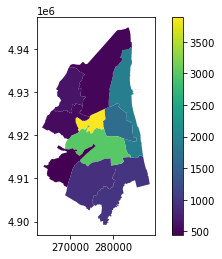

In [8]:
distribution_count = distribution[["frazione", 'ateco_cod']]
distribution_count = distribution_count.rename(columns = { 'ateco_cod' : 'imprese_num' }) #prepare for count
distribution_count = distribution_count.groupby('frazione').count().reset_index()
distribution_count = distribution_count.merge(areas, on = "frazione")
distribution_count = gpd.GeoDataFrame(distribution_count)
# print(isinstance(distribution_count, gpd.GeoDataFrame))
print(distribution_count[['frazione', 'imprese_num']])
distribution_count.plot(column='imprese_num', legend = True)

### Variety

In [9]:
variety = imprese
variety['ateco_cod'] = variety['ateco_cod'].str.split(pat='.')
variety['ateco_cod'] = variety['ateco_cod'].str.get(0)

Grouped by first level classification: ateco 00.00.00 as level1.level2.level3  
For the whole area the following will be calculated:
- Total number of company types  
- Top 10 categories

total number of company types: 80


<AxesSubplot:ylabel='ateco_nome'>

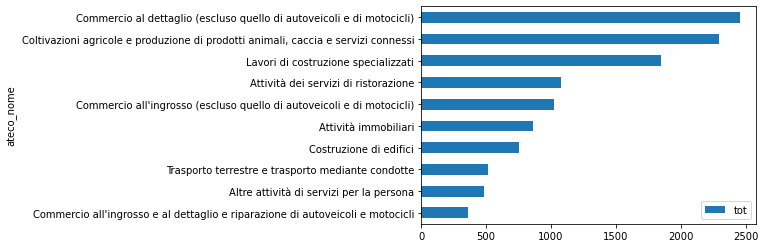

In [10]:
variety_tot = variety[['geometry', 'ateco_cod']].groupby('ateco_cod').count().reset_index()
variety_tot = variety_tot.rename(columns = { 'geometry' : 'tot' })
variety_tot = pd.merge( variety_tot, ateco, how = 'left', on = 'ateco_cod' )
variety_tot = variety_tot[['ateco_nome', 'tot']]
print('total number of company types:', variety_tot.shape[0])
variety_tot['tot'] = variety_tot['tot'].nlargest(n = 10)
variety_tot = variety_tot.dropna( subset = ['tot'] )
variety_tot = variety_tot.sort_values( by = ['tot'] )
# print(variety_tot)
variety_tot.plot.barh( x = 'ateco_nome', y = 'tot' )

Districts breakdown

In [11]:
variety_distr = areas.overlay(variety, how = "intersection", keep_geom_type=False)
variety_distr = variety_distr.drop_duplicates(subset = ['nome'], ignore_index=True)
variety_distr = variety_distr.groupby('frazione')
# print(variety_distr.head(3)) # shows the first three of each group
print(variety_distr.get_group('DEL MARE').head(3))

   frazione                                               nome ateco_cod  \
0  DEL MARE  FERRAMENTA ZANGAGLIA DI PAOLO E CLAUDIO ZANGAG...        47   
1  DEL MARE  ASSOCIAZIONE COOPERATIVA MURATORI & AFFINI RAV...        41   
2  DEL MARE                   BANCA POPOLARE DI RAVENNA S.P.A.        64   

                                          ateco_nome  \
0  Empori ed altri negozi non specializzati di va...   
1  Costruzione di edifici residenziali e non resi...   
2  Intermediazione monetaria di istituti monetari...   

                         geometry  
0  POINT (283771.377 4929581.233)  
1  POINT (284620.355 4924355.829)  
2  POINT (283506.762 4930217.509)  


In [19]:
def distr_analysis(df_input, str_input):
    df = df_input[['ateco_cod', 'nome']]
    df = df.groupby('ateco_cod').count().reset_index()
    df = df.rename( columns = { 'nome' : 'tot' } )
    df = pd.merge( df, ateco, how = 'left', on = 'ateco_cod' )
    df = df[['ateco_nome', 'tot']]
    print(str_input, 'total number of company types:', df.shape[0])
    df['tot'] = df['tot'].nlargest(n = 10) # mask top 10
    df = df.dropna( subset = ['tot'] ) #keep top 10
    df = df.sort_values( by = ['tot'] )
#     print(df)
    df.plot.barh( x = 'ateco_nome', y = 'tot', title = str_input)
    return

# distr_analysis(variety_distr.get_group('DEL MARE'))

CASTIGLIONE total number of company types: 50
CENTRO URBANO total number of company types: 73
DARSENA total number of company types: 71
DEL MARE total number of company types: 59
MEZZANO total number of company types: 50
PIANGIPANE total number of company types: 45
RAVENNA SUD total number of company types: 68
RONCALCECI total number of company types: 40
SAN PIETRO IN VINCOLI total number of company types: 42
SANT'ALBERTO total number of company types: 31


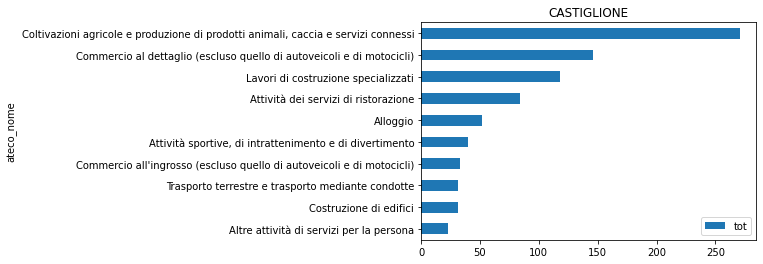

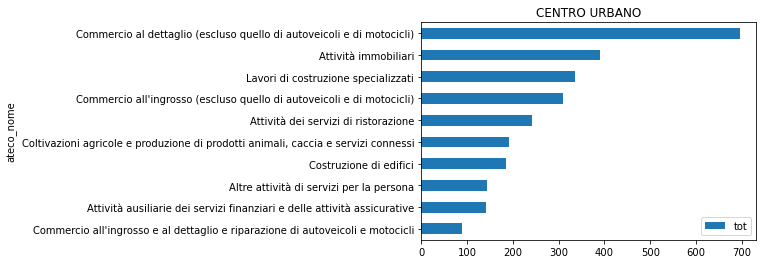

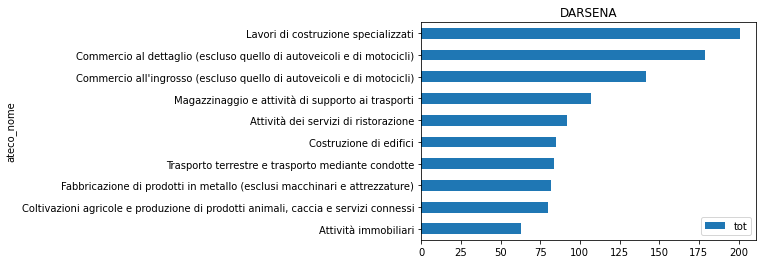

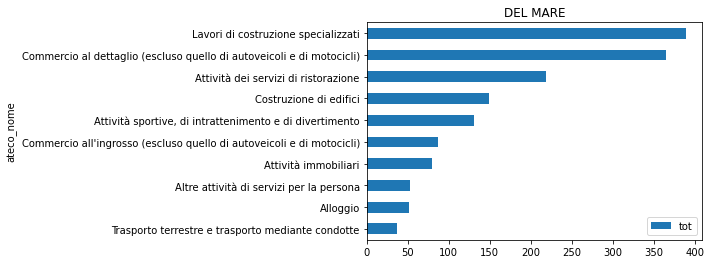

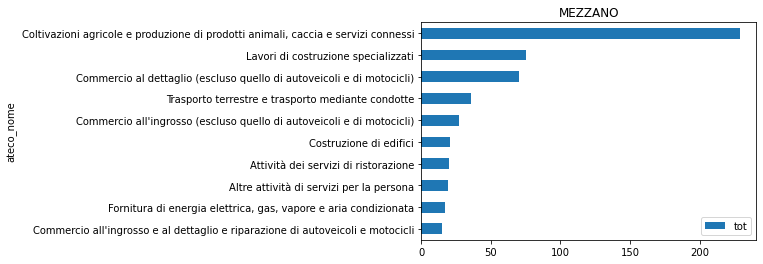

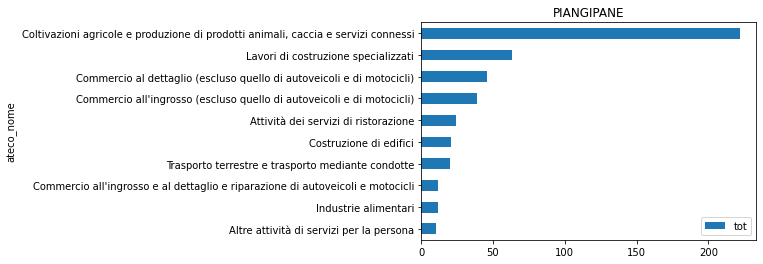

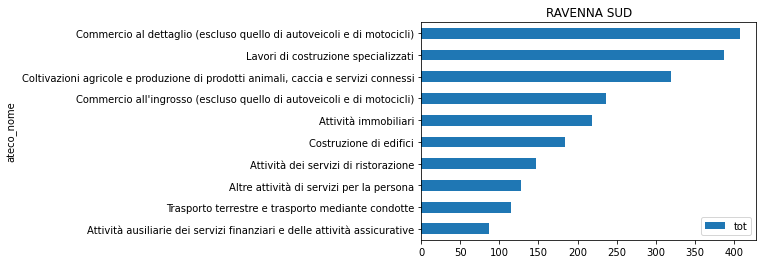

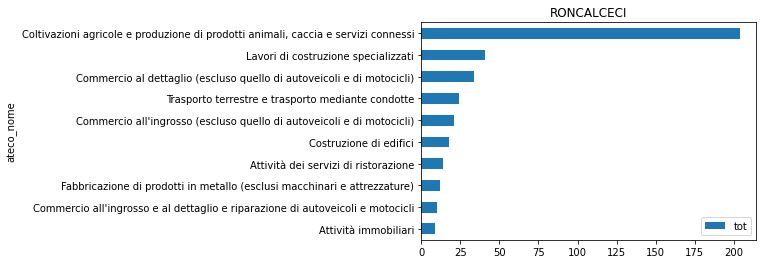

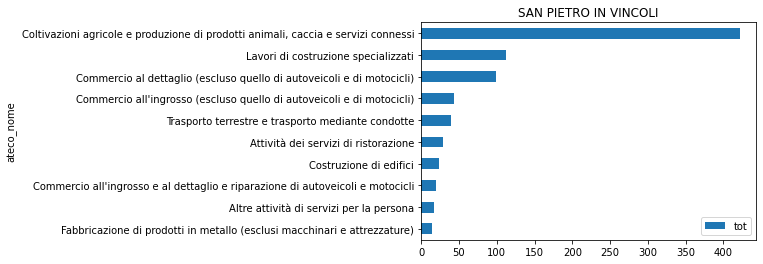

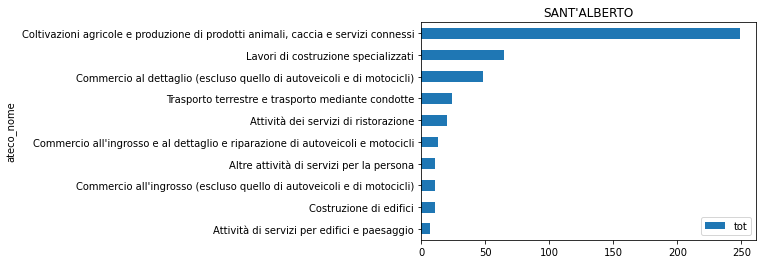

In [20]:
for name, group in variety_distr:
    distr_analysis(group, name)

# I attempted to get tables and graphs together with time.sleep(.5)
# However, the issue persists
# more info at: https://github.com/jupyter/notebook/issues/3159